In [1]:
from time import time

In [2]:
tic = time()

In [3]:
from ship_routing.core import Route, WayPoint
from ship_routing.mc import move_random_node
from ship_routing.currents import load_currents

from matplotlib import pyplot as plt
import numpy as np

In [4]:
np.random.seed(12345)

In [5]:
from copy import deepcopy

In [6]:
import tqdm

In [7]:
currents = load_currents(
    # data_file="data/currents/cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_2021-01_100W-020E_10N-65N.nc"
    data_file="data/currents/cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_2021-01_1deg_5day.nc",
)
currents

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 6, lat: 171, lon: 360)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 684B -79.54 -78.54 -77.54 -76.54 ... 88.46 89.46 90.0
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) datetime64[ns] 48B 2021-01-03 2021-01-08 ... 2021-01-28
Data variables:
    uo       (time, lat, lon) float32 1MB ...
    vo       (time, lat, lon) float32 1MB ...
Attributes:
    Conventions:  CF-1.8
    area:         Global
    contact:      https://marine.copernicus.eu/contact
    credit:       E.U. Copernicus Marine Service Information (CMEMS)
    institution:  Mercator Ocean International
    licence:      http://marine.copernicus.eu/services-portfolio/service-comm...
    producer:     CMEMS - Global Monitoring and Forecasting Centre
    references:   http://marine.copernicus.eu
    source:       MOI GLO12
    title:        daily mean fields from Global Ocean Physics Analysis and Fo...

In [8]:
currents["speed"] = ((currents.to_array() ** 2).sum("variable") ** 0.5).where(
    ~currents.uo.isnull()
)
currents

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 6, lat: 171, lon: 360)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 684B -79.54 -78.54 -77.54 -76.54 ... 88.46 89.46 90.0
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) datetime64[ns] 48B 2021-01-03 2021-01-08 ... 2021-01-28
Data variables:
    uo       (time, lat, lon) float32 1MB nan nan nan nan ... nan nan nan nan
    vo       (time, lat, lon) float32 1MB nan nan nan nan ... nan nan nan nan
    speed    (time, lat, lon) float32 1MB nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.8
    area:         Global
    contact:      https://marine.copernicus.eu/contact
    credit:       E.U. Copernicus Marine Service Information (CMEMS)
    institution:  Mercator Ocean International
    licence:      http://marine.copernicus.eu/services-portfolio/service-comm...
    producer:     CMEMS - Global Monitoring and Forecasting Centre
    references:   http://marine.copernicus.eu
    source:       MOI GLO12
    title:        daily mean fields from Global Ocean Physics Analysis and Fo...

In [9]:
route_0 = Route(
    way_points=(
        WayPoint(lon=-80.5, lat=30, time=np.datetime64("2021-01-01")),
        WayPoint(lon=-40, lat=45, time=np.datetime64("2021-01-21")),
    )
).refine(distance_meters=1_000_000)
route_0

Route(way_points=(WayPoint(lon=-80.5, lat=30, time=numpy.datetime64('2021-01-01')), WayPoint(lon=-71.94751834486507, lat=34.97545585815938, time=numpy.datetime64('2021-01-05T23:59:59.999')), WayPoint(lon=-62.37585689326821, lat=39.27188810472032, time=numpy.datetime64('2021-01-10T23:59:59.999')), WayPoint(lon=-51.698963617395066, lat=42.68494881568617, time=numpy.datetime64('2021-01-15T23:59:59.999')), WayPoint(lon=-40.0, lat=45, time=numpy.datetime64('2021-01-21'))))

In [10]:
route_0.data_frame

,lon,lat,time
0,-80.500000,30.000000,2021-01-01 00:00:00.000
1,-71.947518,34.975456,2021-01-05 23:59:59.999
2,-62.375857,39.271888,2021-01-10 23:59:59.999
3,-51.698964,42.684949,2021-01-15 23:59:59.999
4,-40.000000,45.000000,2021-01-21 00:00:00.000


<Axes: title={'center': 'depth = 0.494 [m]'}, xlabel='lon', ylabel='Latitude [degrees_north]'>

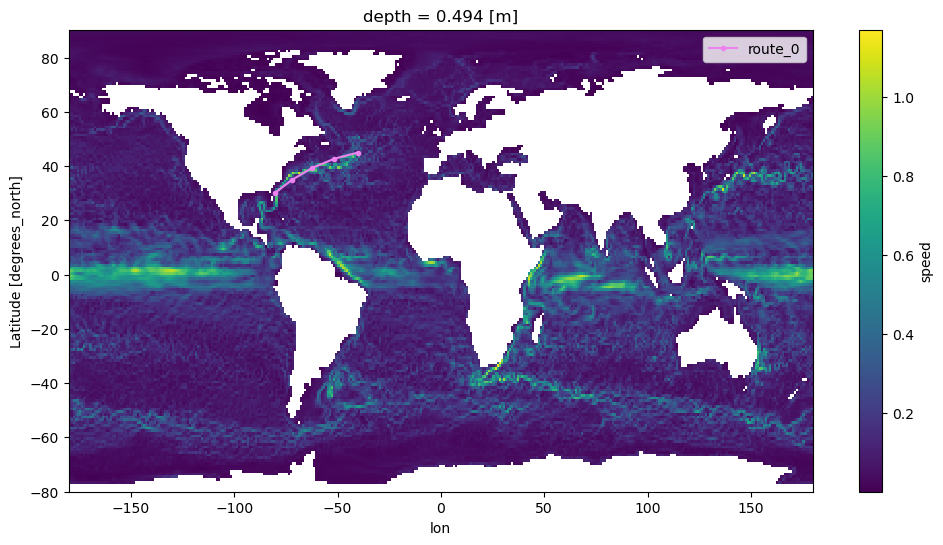

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
currents.speed.mean("time").plot(ax=ax)
route_0.data_frame.plot.line(
    x="lon", y="lat", marker=".", ax=ax, color="violet", label="route_0"
)

In [12]:
route_1 = deepcopy(route_0)
cost = route_1.cost_through(currents)

In [13]:
# cost reduction steps
accepted = 0
for n in tqdm.tqdm(range(100)):
    _route_1 = route_1.move_waypoint(
        azimuth_degrees=np.random.uniform(-180, 180),
        n=np.random.randint(1, len(route_1) - 1),
        distance_meters=np.random.uniform(0, 500_000),
    )
    _cost = _route_1.cost_through(current_data_set=currents)
    if not np.isnan(_cost) and _cost < cost:
        route_1 = _route_1
        cost = _cost
        accepted += 1
print(accepted)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 120.95it/s]

7


In [14]:
route_2 = deepcopy(route_1).refine(500_000)
cost = route_2.cost_through(currents)

In [15]:
# cost reduction steps
accepted = 0
for n in tqdm.tqdm(range(200)):
    _route_2 = route_2.move_waypoint(
        azimuth_degrees=np.random.uniform(-180, 180),
        n=np.random.randint(1, len(route_2) - 1),
        distance_meters=np.random.uniform(0, 250_000),
    )
    _cost = _route_2.cost_through(current_data_set=currents)
    if not np.isnan(_cost) and _cost < cost:
        route_2 = _route_2
        cost = _cost
        accepted += 1
print(accepted)

100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 54.51it/s]

11


In [16]:
route_3 = deepcopy(route_2).refine(250_000)
cost = route_3.cost_through(currents)

In [17]:
# cost reduction steps
accepted = 0
for n in tqdm.tqdm(range(400)):
    _route_3 = route_3.move_waypoint(
        azimuth_degrees=np.random.uniform(-180, 180),
        n=np.random.randint(1, len(route_3) - 1),
        distance_meters=np.random.uniform(0, 100_000),
    )
    _cost = _route_3.cost_through(current_data_set=currents)
    if not np.isnan(_cost) and _cost < cost:
        route_3 = _route_3
        cost = _cost
        accepted += 1
print(accepted)

100%|█████████████████████████████████████████| 400/400 [00:16<00:00, 23.67it/s]

39


In [18]:
route_4 = deepcopy(route_3).refine(100_000)
cost = route_4.cost_through(currents)

In [ ]:
# cost reduction steps
accepted = 0
for n in tqdm.tqdm(range(800)):
    _route_4 = route_4.move_waypoint(
        azimuth_degrees=np.random.uniform(-180, 180),
        n=np.random.randint(1, len(route_4) - 1),
        distance_meters=np.random.uniform(0, 50_000),
    )
    _cost = _route_4.cost_through(current_data_set=currents)
    if not np.isnan(_cost) and _cost < cost:
        route_4 = _route_4
        cost = _cost
        accepted += 1
print(accepted)

 82%|█████████████████████████████████▌       | 654/800 [01:04<00:19,  7.55it/s]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
currents.speed.mean("time").sel(lon=slice(-100, 10), lat=slice(20, 60)).plot(
    ax=ax, alpha=0.6
)
route_0.data_frame.plot.line(x="lon", y="lat", marker=".", ax=ax, label="route_0")
route_1.data_frame.plot.line(x="lon", y="lat", marker=".", ax=ax, label="route_1")
route_2.data_frame.plot.line(x="lon", y="lat", marker=".", ax=ax, label="route_2")
route_3.data_frame.plot.line(x="lon", y="lat", marker=".", ax=ax, label="route_3")
route_4.data_frame.plot.line(x="lon", y="lat", marker=".", ax=ax, label="route_4")

In [ ]:
print(route_0.cost_through(currents))
print(route_1.cost_through(currents))
print(route_2.cost_through(currents))
print(route_3.cost_through(currents))
print(route_4.cost_through(currents))

In [ ]:
print(time() - tic, "seconds")